<a href="https://colab.research.google.com/github/enesertas/computer_vision_step_by_step/blob/main/fine_tuning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configurations

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import vgg19
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import time
import copy
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Hyperparameters
batch_size = 32
num_epochs = 30
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## Loading data and preprocessing

In [ ]:
data_transforms = transforms.Compose([transforms.Resize((60,60)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                          std=[0.25, 0.25, 0.25])
                                     ])

In [ ]:
data_dir = '/content/Vegetable Images' #TODO Paste directory shared link from drive.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train','validation', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train','validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation', 'test']}
class_names = image_datasets['train'].classes

print(class_names)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [ ]:
# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = image_datasets['train'],
                                           batch_size = batch_size,
                                           shuffle = True)

validation_loader = torch.utils.data.DataLoader(dataset = image_datasets['validation'],
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = image_datasets['test'],
                                           batch_size = batch_size,
                                           shuffle = True)

## Fine Tuning Model

#### Get pre-trained model

In [ ]:
model = vgg19(weights='DEFAULT')

#### Adjust classifiers last layers out_features because we have 15 classes instead of 1000

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
model.classifier[6] = nn.Linear(4096, 15)

#### More Hyperparameters

In [ ]:
# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

#### Move model to GPU (CUDA)

In [ ]:
model = model.to(device)

#### Keep track of training process in these variables

In [ ]:
train_losses_1 = []
train_accuracies_1 = []
val_losses_1 = []
val_accuracies_1 = [] 

#### Training Pipeline

In [ ]:
since = time.time()
early_stopping_patience = 5
early_stopping = False
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
best_acc = torch.tensor([0.0]).cuda()

# Main training loop

for epoch in range(num_epochs):
    if early_stopping:
      break;
    print('Epoch [{}/{}]'.format(epoch, num_epochs - 1), end=" ")

    # Each epoch has a training and a validation phase

    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train() # If phase train train model
        else:
            model.eval() # If not evaluate model
        running_loss = 0.0
        running_corrects = 0
        # For each input and label:
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Feed Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # Backpropogate
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            # Calculations
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
            train_losses_1.append(epoch_loss)
            train_accuracies_1.append(epoch_acc.item())
        if phase == 'validation':
            val_losses_1.append(epoch_loss)
            val_accuracies_1.append(epoch_acc.item())
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc), end=" ")
        if phase == 'validation' and epoch_acc > best_acc and (epoch+1)%early_stopping_patience==0:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        elif phase == 'validation' and epoch_acc <= best_acc and (epoch+1)%early_stopping_patience==0:
            print()
            print("Early Stopping!")
            early_stopping = True
    print('Saved Accuracy:', best_acc.item())
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))
model.load_state_dict(best_model_wts)

Epoch [0/29] train Loss: 0.3565 Acc: 0.8927 validation Loss: 0.0510 Acc: 0.9850 Saved Accuracy: 0.0
Epoch [1/29] train Loss: 0.0458 Acc: 0.9856 validation Loss: 0.0295 Acc: 0.9930 Saved Accuracy: 0.0
Epoch [2/29] train Loss: 0.0258 Acc: 0.9926 validation Loss: 0.0198 Acc: 0.9937 Saved Accuracy: 0.0
Epoch [3/29] train Loss: 0.0083 Acc: 0.9972 validation Loss: 0.0238 Acc: 0.9930 Saved Accuracy: 0.0
Epoch [4/29] train Loss: 0.0035 Acc: 0.9990 validation Loss: 0.0104 Acc: 0.9973 Saved Accuracy: 0.9973333333333333
Epoch [5/29] train Loss: 0.0013 Acc: 0.9999 validation Loss: 0.0120 Acc: 0.9967 Saved Accuracy: 0.9973333333333333
Epoch [6/29] train Loss: 0.0011 Acc: 0.9999 validation Loss: 0.0103 Acc: 0.9970 Saved Accuracy: 0.9973333333333333
Epoch [7/29] train Loss: 0.0010 Acc: 0.9999 validation Loss: 0.0099 Acc: 0.9970 Saved Accuracy: 0.9973333333333333
Epoch [8/29] train Loss: 0.0010 Acc: 0.9999 validation Loss: 0.0097 Acc: 0.9977 Saved Accuracy: 0.9973333333333333
Epoch [9/29] train Loss: 

<All keys matched successfully>

#### Get predictions by model using test_data

In [ ]:
# Get predictions over test data;

y_pred_1 = []
y_true_1 = []

model.eval()

for inputs, labels in test_loader:

    inputs = inputs.to(device)
    labels = labels.to(device)

    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred_1.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true_1.extend(labels) # Save Truth

## Fine Tuning Only FC1 and FC2

#### Get Model

In [ ]:
model = vgg19(weights='DEFAULT')

#### Freeze all the layers

In [ ]:
for param in model.parameters():
    param.requires_grad = False

#### Re-initialize classifier because it includes FC1 and FC2, also we need to change out_features

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
 nn.ReLU(inplace=True),
 nn.Dropout(p=0.5, inplace=False),
 nn.Linear(in_features=4096, out_features=4096, bias=True),
 nn.ReLU(inplace=True),
 nn.Dropout(p=0.5, inplace=False),
 nn.Linear(in_features=4096, out_features=15, bias=True))

#### Hyperparameters

In [ ]:
# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

#### Send model to GPU

In [ ]:
model = model.to(device)

#### To be able to visualize training process later

In [ ]:
train_losses_2 = []
train_accuracies_2 = []
val_losses_2 = []
val_accuracies_2 = [] 

#### Training Pipeline

In [ ]:
since = time.time()
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
best_acc = torch.tensor([0.0]).cuda()
early_stopping = False
early_stopping_patience = 5

# Main training loop

for epoch in range(num_epochs):
    if early_stopping:
      break;
    print('Epoch [{}/{}]'.format(epoch, num_epochs - 1), end=" ")

    # Each epoch has a training and a validation phase
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()  # Train model if phase train
        else:
            model.eval()   # Evaluate model if phase not train
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Feed Forward.

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Back Propagate.

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
            train_losses_2.append(epoch_loss)
            train_accuracies_2.append(epoch_acc.item())
        if phase == 'validation':
            val_losses_2.append(epoch_loss)
            val_accuracies_2.append(epoch_acc.item())
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc), end=" ")
        if phase == 'validation' and epoch_acc > best_acc and (epoch+1)%early_stopping_patience==0:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        elif phase == 'validation' and epoch_acc <= best_acc and (epoch+1)%early_stopping_patience==0:
            print()
            print("Early Stopping!")
            early_stopping = True
    print("Saved Accuracy:", best_acc.item())
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))
model.load_state_dict(best_model_wts)

Epoch [0/29] train Loss: 0.8762 Acc: 0.7341 validation Loss: 0.4155 Acc: 0.8767 Saved Accuracy: 0.0
Epoch [1/29] train Loss: 0.4104 Acc: 0.8685 validation Loss: 0.3521 Acc: 0.8873 Saved Accuracy: 0.0
Epoch [2/29] train Loss: 0.2989 Acc: 0.9063 validation Loss: 0.2480 Acc: 0.9203 Saved Accuracy: 0.0
Epoch [3/29] train Loss: 0.2406 Acc: 0.9203 validation Loss: 0.2184 Acc: 0.9310 Saved Accuracy: 0.0
Epoch [4/29] train Loss: 0.1990 Acc: 0.9349 validation Loss: 0.1966 Acc: 0.9363 Saved Accuracy: 0.9363333333333334
Epoch [5/29] train Loss: 0.1736 Acc: 0.9441 validation Loss: 0.1821 Acc: 0.9407 Saved Accuracy: 0.9363333333333334
Epoch [6/29] train Loss: 0.1489 Acc: 0.9513 validation Loss: 0.1726 Acc: 0.9480 Saved Accuracy: 0.9363333333333334
Epoch [7/29] train Loss: 0.1067 Acc: 0.9675 validation Loss: 0.1481 Acc: 0.9543 Saved Accuracy: 0.9363333333333334
Epoch [8/29] train Loss: 0.0972 Acc: 0.9708 validation Loss: 0.1451 Acc: 0.9573 Saved Accuracy: 0.9363333333333334
Epoch [9/29] train Loss: 

<All keys matched successfully>

#### Make trained model predict new images from test set

In [ ]:
# Get predictions over test data;

y_pred_2 = []
y_true_2 = []

model.eval()

for inputs, labels in test_loader:

    inputs = inputs.to(device)
    labels = labels.to(device)

    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred_2.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true_2.extend(labels) # Save Truth

## Evaluation

In [ ]:
print(train_losses_1)
print(train_accuracies_1)
print(val_losses_1)
print(val_accuracies_1)
print(train_losses_2)
print(train_accuracies_2)
print(val_losses_2)
print(val_accuracies_2)

[0.35653260055445135, 0.04579086263198406, 0.025750282087735832, 0.008338344221267228, 0.0034721516946408276, 0.0012897077823717457, 0.0011484865702145422, 0.0010024164977638671, 0.001026503862370737, 0.0010042139626534965]
[0.8927333333333334, 0.9856, 0.9926, 0.9972000000000001, 0.999, 0.9998666666666667, 0.9999333333333333, 0.9999333333333333, 0.9999333333333333, 1.0]
[0.051027761505916716, 0.029470740125204127, 0.019774997272528707, 0.0237939129145816, 0.01040407517158504, 0.012016305108942712, 0.010258030708219545, 0.009883971715035538, 0.009685723060625605, 0.010067992743027086]
[0.985, 0.993, 0.9936666666666666, 0.993, 0.9973333333333333, 0.9966666666666666, 0.997, 0.997, 0.9976666666666666, 0.9966666666666666]
[0.8762479480743408, 0.4104421940088272, 0.29892234426339465, 0.2405753971497218, 0.19895941603183748, 0.1735558369040489, 0.1488652293930451, 0.106709345159928, 0.09717722201744715, 0.0846477432479461, 0.08291826803485552, 0.08156183984627326, 0.07517212059994538, 0.07131

Text(0.5, 1.0, 'Part 2.1 Model Training Process')

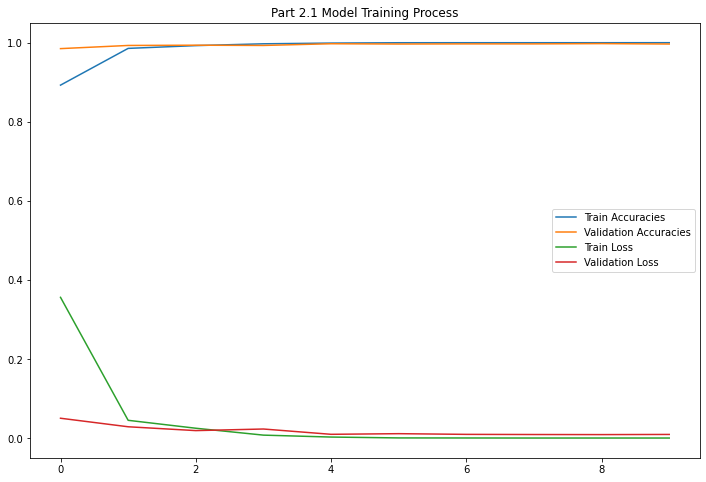

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train_accuracies_1)
plt.plot(val_accuracies_1)
plt.plot(train_losses_1)
plt.plot(val_losses_1)
plt.legend(['Train Accuracies', 'Validation Accuracies', 'Train Loss', 'Validation Loss'], loc="center right")
plt.title('Part 2.1 Model Training Process')

Text(0.5, 1.0, 'Part 2.2 Model Training Process')

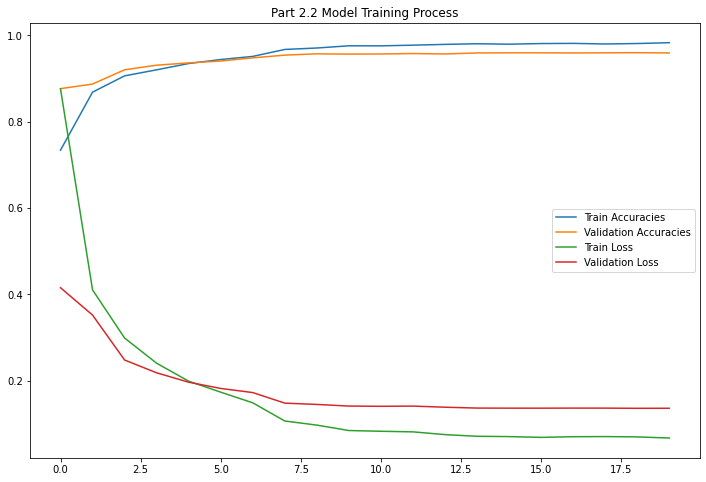

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train_accuracies_2)
plt.plot(val_accuracies_2)
plt.plot(train_losses_2)
plt.plot(val_losses_2)
plt.legend(['Train Accuracies', 'Validation Accuracies', 'Train Loss', 'Validation Loss'], loc='center right')
plt.title('Part 2.2 Model Training Process')

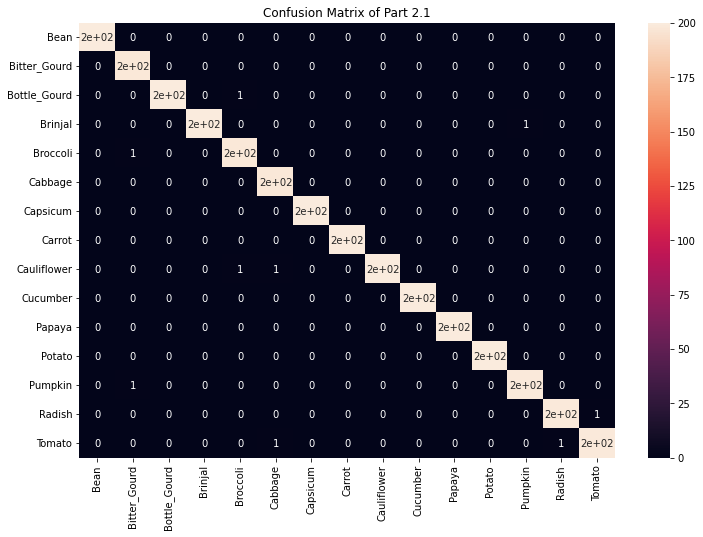

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Confusion Matrix of Part 2.1')
sns.heatmap(confusion_matrix(y_pred_1, y_true_1), annot=True, xticklabels=class_names, yticklabels=class_names)

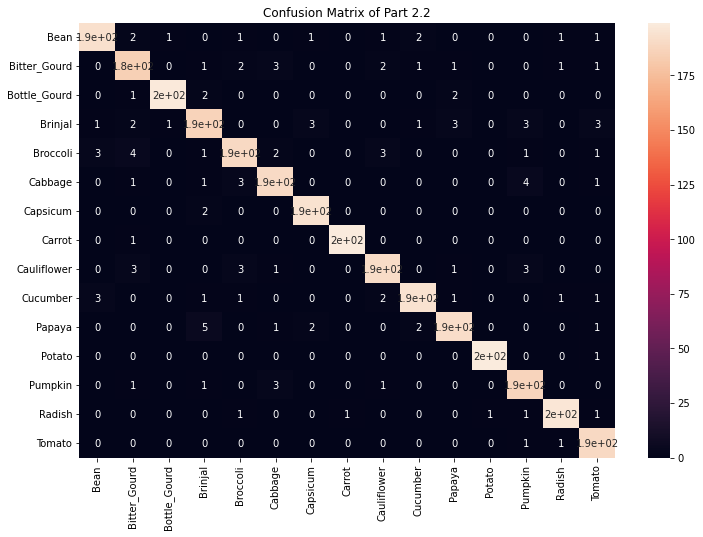

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Confusion Matrix of Part 2.2')
sns.heatmap(confusion_matrix(y_pred_2, y_true_2), annot=True, xticklabels=class_names, yticklabels=class_names)

In [ ]:
print("Classification Report of Part 2.1 (Whole Model)\n")
print(classification_report(y_true_1,y_pred_1))

Classification Report of Part 2.1 (Whole Model)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      0.99      0.99       200
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       200
           4       0.99      0.99      0.99       200
           5       1.00      0.99      0.99       200
           6       1.00      1.00      1.00       200
           7       1.00      1.00      1.00       200
           8       0.99      1.00      1.00       200
           9       1.00      1.00      1.00       200
          10       1.00      1.00      1.00       200
          11       1.00      1.00      1.00       200
          12       0.99      0.99      0.99       200
          13       0.99      0.99      0.99       200
          14       0.99      0.99      0.99       200

    accuracy                           1.00      3000
   macro avg       1.00      1.

In [ ]:
print("Classification Report of Part 2.2 (Only FC1 and FC2)\n")
print(classification_report(y_true_2,y_pred_2))

Classification Report of Part 2.2 (Only FC1 and FC2)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       200
           1       0.94      0.93      0.93       200
           2       0.98      0.99      0.98       200
           3       0.92      0.93      0.92       200
           4       0.93      0.94      0.94       200
           5       0.95      0.95      0.95       200
           6       0.99      0.97      0.98       200
           7       0.99      0.99      0.99       200
           8       0.95      0.95      0.95       200
           9       0.95      0.97      0.96       200
          10       0.95      0.96      0.95       200
          11       0.99      0.99      0.99       200
          12       0.97      0.94      0.95       200
          13       0.98      0.98      0.98       200
          14       0.99      0.94      0.97       200

    accuracy                           0.96      3000
   macro avg       0.96   